In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [83]:
train = pd.read_csv('Desktop/Python/Kaggle/titanic/train.csv')
test = pd.read_csv('Desktop/Python/Kaggle/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [84]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
full_data = [train, test]
#full_data[:5]

In [7]:
# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# Feature that tell whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [8]:
# Create new feature FamilySize as a combination of SibSP and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [9]:
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize']==1, 'IsAlone'] = 1

In [10]:
# Remove all Nulls in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [11]:
# Remove all Nulls in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

In [12]:
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [13]:
# Define function to extract titles from passeger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # if the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [14]:
# Create a new featrue Title, containg the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [15]:
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt',
                                               'Col', 'Don', 'Dr', 'Major', 'Rev', 
                                               'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [16]:
for dataset in full_data:
    # Mapping sex
    dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)        

In [17]:
for dataset in full_data: 
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [18]:
for dataset in full_data:
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q': 2}).astype(int)

In [19]:
for dataset in full_data:
    # Mapping Fare
    dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <=14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [20]:
for dataset in full_data:
    # Mapping Age
    dataset.loc[dataset['Age']<=16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[dataset['Age'] > 64, 'Age'] = 4

In [21]:
dataset.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,3


In [22]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis=1)

In [23]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


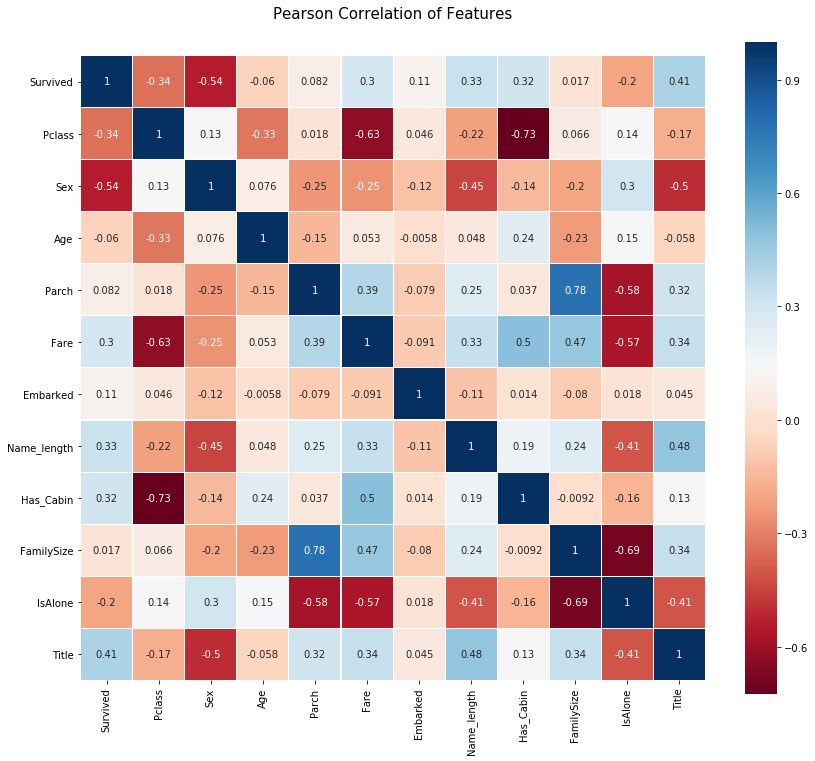

In [24]:
"""Pearson Correlation Heatmap"""
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
           square=True, cmap=colormap, linecolor='white', annot=True)

In [25]:
"""One thing that that the Pearson Correlation plot can tell us 
is that there are not too many features strongly correlated with
one another. This is good from a point of view of feeding these 
features into your learning model because this means that there 
isn't much redundant or superfluous data in our training set 
and we are happy that each feature carries with it some unique 
information. Here are two most correlated features are that of 
Family size and Parch (Parents and Children). I'll still leave 
both features in for the purposes of this exercise.
"""

"One thing that that the Pearson Correlation plot can tell us \nis that there are not too many features strongly correlated with\none another. This is good from a point of view of feeding these \nfeatures into your learning model because this means that there \nisn't much redundant or superfluous data in our training set \nand we are happy that each feature carries with it some unique \ninformation. Here are two most correlated features are that of \nFamily size and Parch (Parents and Children). I'll still leave \nboth features in for the purposes of this exercise.\n"

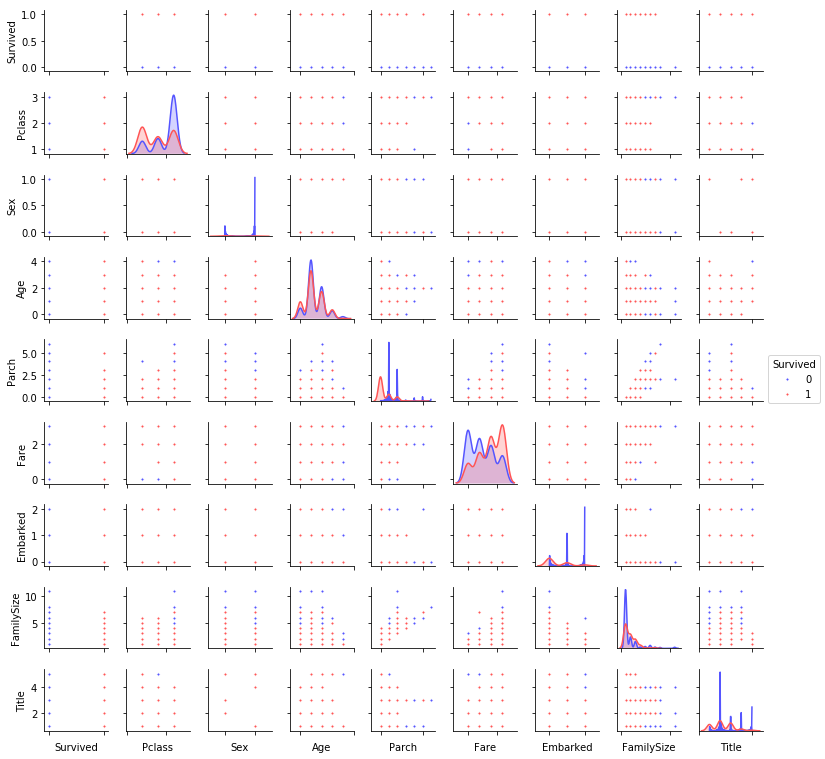

In [26]:
# Pairplots
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                       u'Embarked', u'FamilySize', u'Title']], hue='Survived', palette='seismic', size=1.2, 
                 diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

In [27]:
# some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

In [28]:
# Class to extend the sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
    
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
        
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)

# Class to extend XGboost classifier

In [29]:
"""Out-of-Fold Predictions
one cannot simply train the base models on the full training data, 
generate predictions on the full test set and then output these 
for the second-level training. This runs the risk of your base model 
predictions already having "seen" the test set and therefore overfitting 
when feeding these predictions."""

'Out-of-Fold Predictions\none cannot simply train the base models on the full training data, \ngenerate predictions on the full test set and then output these \nfor the second-level training. This runs the risk of your base model \npredictions already having "seen" the test set and therefore overfitting \nwhen feeding these predictions.'

In [30]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [31]:
# Generating our Base First-Level Models
"""
So now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:

Random Forest classifier
Extra Trees classifier
AdaBoost classifer
Gradient Boosting classifer
Support Vector Machine
"""

'\nSo now let us prepare five learning models as our first level classification. These models can all be conveniently invoked via the Sklearn library and are listed as follows:\n\nRandom Forest classifier\nExtra Trees classifier\nAdaBoost classifer\nGradient Boosting classifer\nSupport Vector Machine\n'

In [32]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start':  True,
    # 'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}

In [33]:
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf':2,
    'verbose': 0
}

In [34]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

In [35]:
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf':2,
    'verbose': 0
}

In [36]:
# Support Vector Classifier parameters
svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [37]:
"""Furthermore, since having mentioned about Objects and classes within 
the OOP framework, let us now create 5 objects that represent our 5 learning
models via our Helper Sklearn Class we defined earlier."""

'Furthermore, since having mentioned about Objects and classes within \nthe OOP framework, let us now create 5 objects that represent our 5 learning\nmodels via our Helper Sklearn Class we defined earlier.'

In [38]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [39]:
# Create Numpy arrays of train, test and target (survived) dataframes to feed into our model
y_train = train['Survived'].ravel()
train = train.drop(['Survived'], axis=1)
x_train = train.values # Creates an array of the train data
x_test = test.values # Creates an array of the test data

In [40]:
"""Output of the First level Predictions
We now feed the training and test data into our 5 base classifiers and 
use the Out-of-Fold prediction function we defined earlier to generate our 
first level predictions. Allow a handful of minutes for the chunk of code 
below to run.
"""

'Output of the First level Predictions\nWe now feed the training and test data into our 5 base classifiers and \nuse the Out-of-Fold prediction function we defined earlier to generate our \nfirst level predictions. Allow a handful of minutes for the chunk of code \nbelow to run.\n'

In [41]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test) #Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test) # Support Vectorn Classifier
print("Training is complete")

Training is complete


In [43]:
# feature importances generated from the different classifiers
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.1252703  0.20191352 0.0296075  0.02098196 0.07185189 0.02354376
 0.10692431 0.06521313 0.06952717 0.01338067 0.27178577]
[0.12170471 0.37809538 0.02848909 0.0169617  0.05583811 0.02756228
 0.04736671 0.08190587 0.04455743 0.02193059 0.17558815]
[0.03  0.012 0.016 0.066 0.036 0.008 0.692 0.012 0.054 0.004 0.07 ]
[0.07855515 0.03686956 0.09242062 0.03227243 0.10897442 0.04610318
 0.38574444 0.01958918 0.08287618 0.02797549 0.08861935]


In [47]:
rf_features = [0.1252703, 0.20191352, 0.0296075,  0.02098196, 0.07185189, 0.02354376,
 0.10692431, 0.06521313, 0.06952717, 0.01338067, 0.27178577]
et_features = [0.12170471, 0.37809538, 0.02848909, 0.0169617,  0.05583811, 0.02756228,
 0.04736671, 0.08190587, 0.04455743, 0.02193059, 0.17558815]
ada_features = [0.03, 0.012, 0.016, 0.066, 0.036, 0.008, 0.692, 0.012, 0.054, 0.004, 0.07]
gb_features = [0.07855515, 0.03686956, 0.09242062, 0.03227243, 0.10897442, 0.04610318,
 0.38574444, 0.01958918, 0.08287618, 0.02797549, 0.08861935]

In [57]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features': cols,
                                 'Random Forest feature importances': rf_features,
                                 'Extra Trees feature importances': et_features,
                                 'AdaBoost feature importances': ada_features,
                                 'Gradient Boost feature importances': gb_features})
feature_dataframe

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features
0,0.030,0.121705,0.078555,0.125270,Pclass
1,0.012,0.378095,0.036870,0.201914,Sex
2,0.016,0.028489,0.092421,0.029607,Age
3,0.066,0.016962,0.032272,0.020982,Parch
4,0.036,0.055838,0.108974,0.071852,Fare
5,0.008,0.027562,0.046103,0.023544,Embarked
6,0.692,0.047367,0.385744,0.106924,Name_length
7,0.012,0.081906,0.019589,0.065213,Has_Cabin
8,0.054,0.044557,0.082876,0.069527,FamilySize
9,0.004,0.021931,0.027975,0.013381,IsAlone


In [50]:
"""Interactive feature importances via Plotly scatterplots"""

'Interactive feature importances via Plotly scatterplots'

In [55]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Random Forest Feature Importance',
    hovermode = 'closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [58]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Extra Trees Feature Importance',
    hovermode = 'closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [61]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'AdaBoost Feature Importance',
    hovermode = 'closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [63]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode = 'markers',
    marker = dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize = True,
    title = 'Gradient Boost Feature Importance',
    hovermode = 'closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

In [65]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis=1) # axis=1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.030,0.121705,0.078555,0.125270,Pclass,0.088883
1,0.012,0.378095,0.036870,0.201914,Sex,0.157220
2,0.016,0.028489,0.092421,0.029607,Age,0.041629


In [66]:
# Plotly Barplot Average Feature Importances
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x = x,
            y = y,
            width = 0.5,
            marker=dict(
                color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale=False
            ),
            opacity=0.6
        )]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title = 'Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [67]:
"""Second-Level Predictions from the First-level Output"""

'Second-Level Predictions from the First-level Output'

In [70]:
base_predictions_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTrees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()
                                      })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [71]:
# Correlation Heatmap of the Second Level Training set
data = [
    go.Heatmap(
        z = base_predictions_train.astype(float).corr().values,
        x = base_predictions_train.columns.values,
        y = base_predictions_train.columns.values,
            colorscale = 'Viridis',
            showscale = True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [72]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train,
                          svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test,
                       svc_oof_test), axis=1)

In [73]:
"""Second level learning model via XGBoost"""

'Second level learning model via XGBoost'

In [74]:
#Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned 
#model to predict the test data as follows:

In [75]:
gbm = xgb.XGBClassifier(
    # learning_rate = 0.02,
 n_estimators = 2000,
 max_depth = 4, #How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.
 min_child_weight = 2,
 #gamma=1,
 gamma = 0.9, #minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.
 subsample=0.8,
 colsample_bytree=0.8,
 objective='binary:logistic',
 nthread=-1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [85]:
# Generate Submission File
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                  'Survived':predictions})
StackingSubmission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
